In [1]:
import numpy as np 
import ghibtools as gh
import mne
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
qui = 'Matthias'

In [3]:
file = f'../Data/Pilotes/{qui}_test.vhdr'

In [4]:
raw = mne.io.read_raw_brainvision(file)

Extracting parameters from ../Data/Pilotes/Matthias_test.vhdr...
Setting channel info structure...


/tmp/ipykernel_287247/3705537657.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_287247/3705537657.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_287247/3705537657.py:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_287247/3705537657.py:1: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw 

In [5]:
srate = 1000
data = raw.get_data()
chans = raw.info['ch_names']
time = np.arange(0 , data.shape[1]/ srate , 1 / srate)

In [6]:
da = xr.DataArray(data=data , dims = ['chan','time'], coords = {'chan':chans, 'time':time})

In [7]:
%matplotlib widget

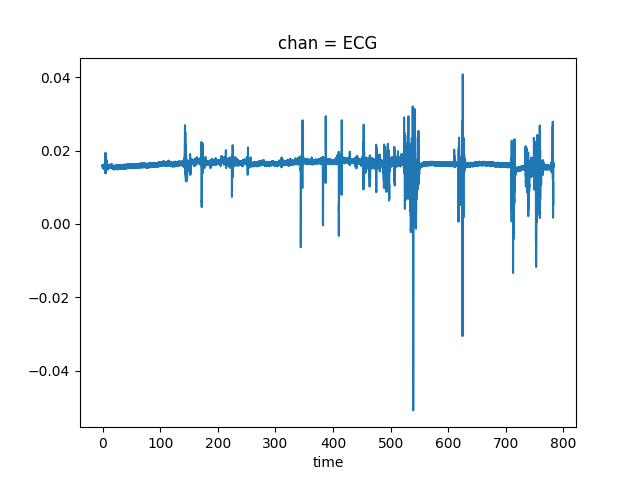

In [46]:
plt.figure()
da.loc['ECG',:].plot()
plt.show()

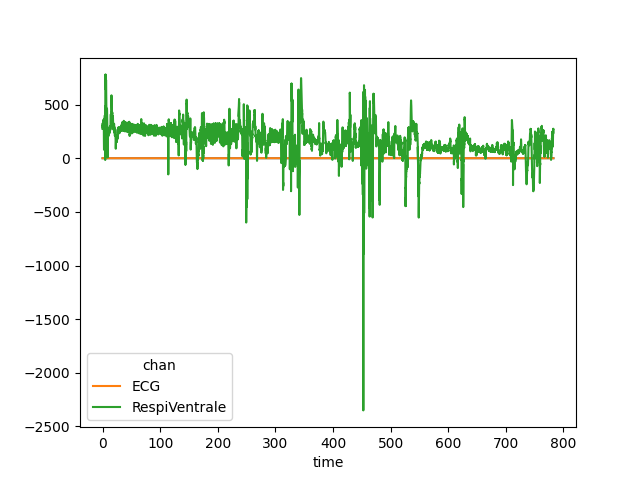

In [9]:
da.loc[['ECG','RespiVentrale'],:].plot.line(x='time')
plt.show()

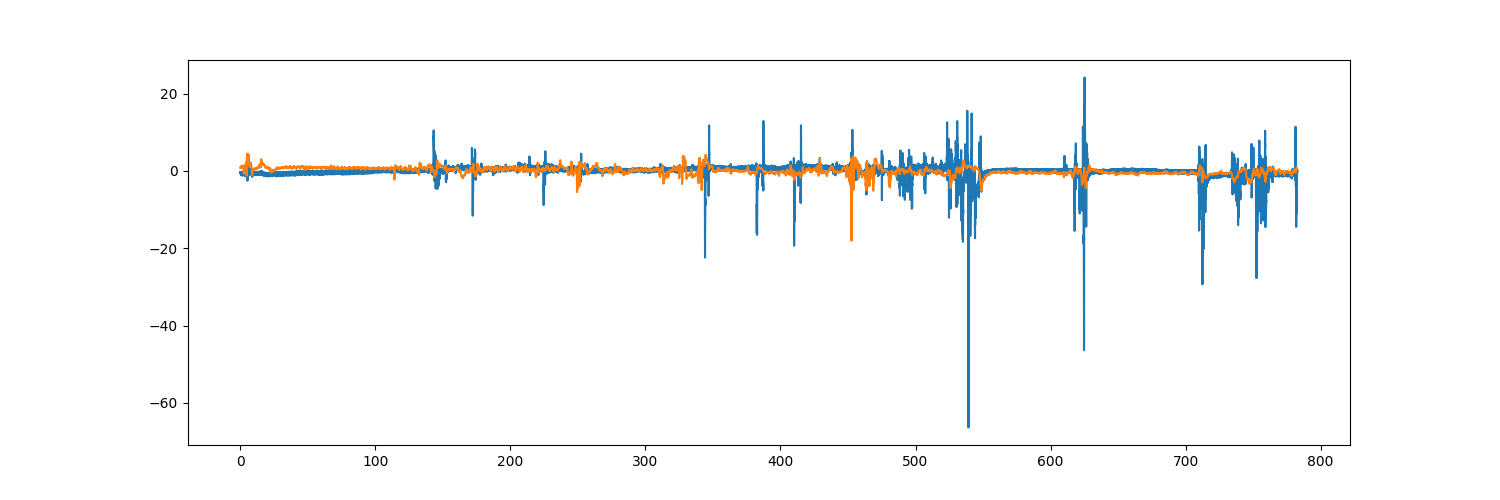

In [10]:
ecg = da.loc['ECG',:].values
respi = da.loc['RespiVentrale',:].values
time = da.coords['time'].values

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(time, gh.norm(ecg) * 2)
ax.plot(time, gh.norm(respi))
plt.show()

In [11]:
f, Pxx = gh.spectre(respi, srate, lowest_freq = 0.5)

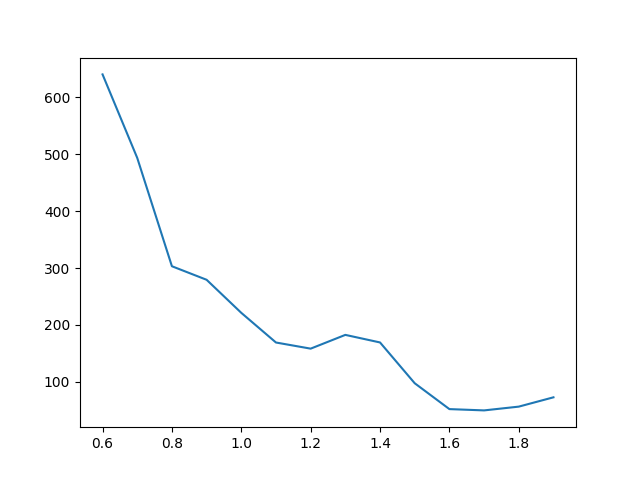

In [12]:
mask = (f > 0.5) & (f < 2)
fig, ax = plt.subplots()
ax.plot(f[mask], Pxx[mask])


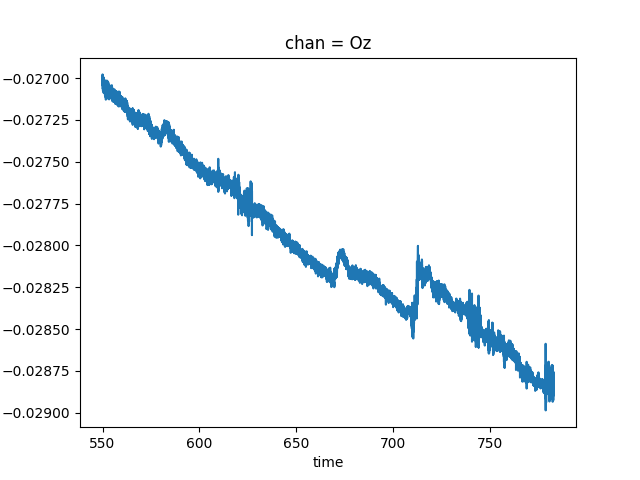

In [49]:
plt.figure()
da.loc['Oz',550:].plot()
plt.show()

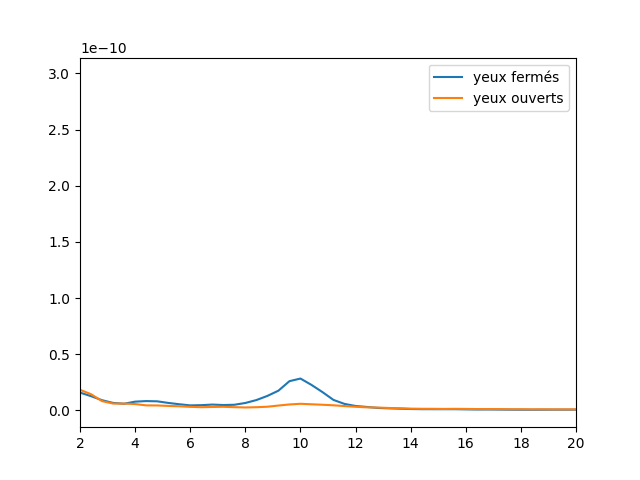

In [60]:
# mask = (f > 2) & (f < 20)
sig1 = da.loc['Oz',550:730].values
f, Pxx1 = gh.spectre(sig1, srate, lowest_freq = 2)

sig2 = da.loc['Oz',0:550].values
f, Pxx2 = gh.spectre(sig2, srate, lowest_freq = 2)

fig, ax = plt.subplots()
ax.plot(f, Pxx1, label = 'yeux fermés')
ax.plot(f, Pxx2, label = 'yeux ouverts')
ax.set_xlim(2 , 20)
ax.legend()

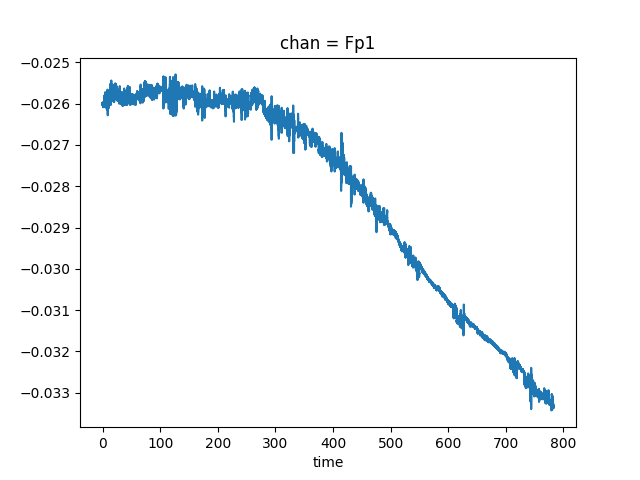

In [13]:
plt.figure()
da.loc['Fp1',:].plot()
plt.show()

In [14]:
da.loc['ECG',:].values.shape

(782620,)

In [15]:
gh

<module 'ghibtools' from '/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/__init__.py'>

In [16]:
ecg = da.loc['ECG',:].values
ecg_filtered = gh.iirfilt(ecg, srate, lowcut = 5 , highcut = 45, order = 4 , verbose = False, show = False) 
ecg_filered_2 = gh.iirfilt(ecg, srate, lowcut = 5 , highcut = 15, order = 4 , verbose = False, show = False) 

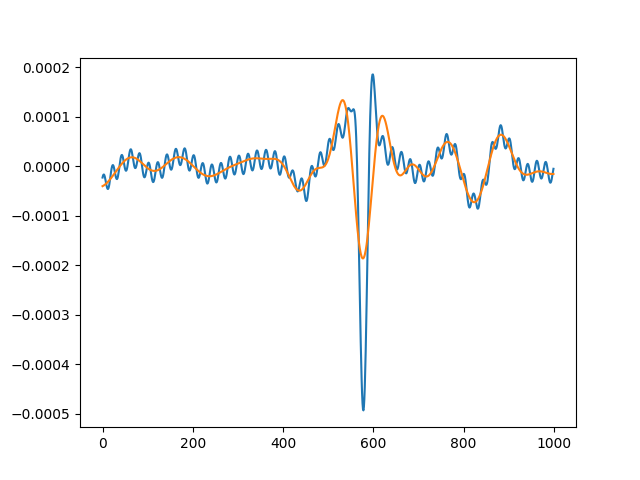

In [17]:
fig, ax = plt.subplots()
# ax.plot(time, ecg)
ax.plot(ecg_filtered[10000:11000])
ax.plot(ecg_filered_2[10000:11000])
plt.show()

In [18]:
peaks = gh.ecg_peaks(ecg_filtered, srate)

In [19]:
peaks

array([   468,   1356,   2259,   3196,   4070,   6463,   7203,   7961,
         8759,   9583,  10599,  11614,  12596,  13509,  14362,  15144,
        15906,  16660,  17434,  18195,  18957,  19845,  20962,  21972,
        22958,  23922,  24840,  25780,  26745,  27739,  28669,  29606,
        30596,  31588,  32509,  33481,  34466,  35413,  36393,  37361,
        38252,  39184,  40135,  41050,  41961,  42943,  43852,  44761,
        45741,  46642,  47522,  48464,  49425,  50316,  51264,  52230,
        53147,  54081,  55066,  56004,  56909,  57897,  58885,  59798,
        60761,  61753,  62696,  63613,  64622,  65566,  66490,  67459,
        68360,  69289,  70223,  71115,  72072,  73011,  73894,  74877,
        75842,  76758,  77735,  78684,  79598,  80562,  81536,  82471,
        83409,  84389,  85332,  86233,  87208,  88189,  89110,  90099,
        91106,  92061,  93037,  94058,  94945,  95797,  96705,  97741,
        98779,  99748, 100714, 101756, 102801, 103785, 104819, 105834,
      

In [20]:
peaks_sel = peaks[(peaks > 10000) & (peaks < 20000)] - 10000

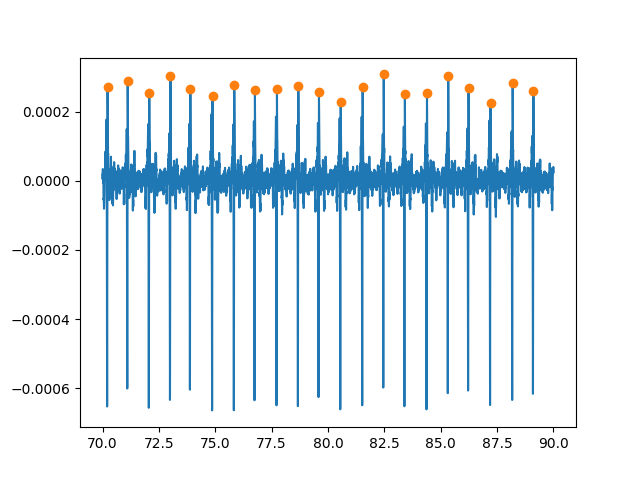

In [21]:
start = 70000
stop = 90000

peaks_sel = peaks[(peaks > start) & (peaks < stop)] - start
fig, ax = plt.subplots()
ax.plot(time[start:stop], ecg_filtered[start:stop])
ax.plot(time[start:stop][peaks_sel], ecg_filtered[start:stop][peaks_sel], 'o')
plt.show()

In [22]:
fci = gh.ecg_to_hrv(ecg, srate)

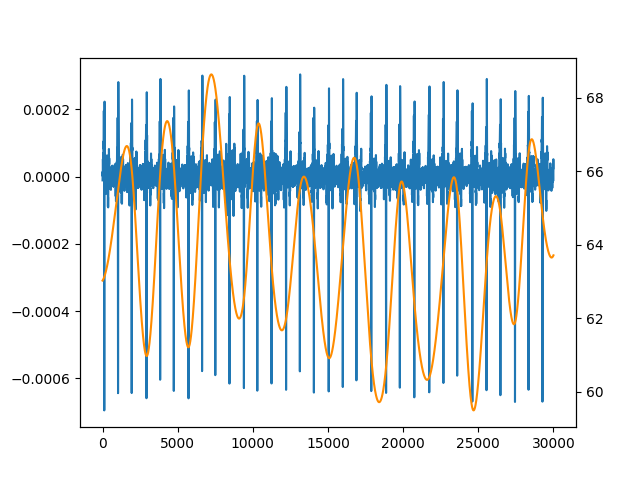

In [23]:
fig, ax = plt.subplots()
start = 40000
stop = 70000
ax.plot(ecg_filtered[start:stop])

ax2 = ax.twinx()
ax2.plot(fci[start:stop], color = 'darkorange')
plt.show()

In [24]:
ecg.shape

(782620,)

In [25]:
fci.shape

(782620,)

In [26]:
peaks

array([   468,   1356,   2259,   3196,   4070,   6463,   7203,   7961,
         8759,   9583,  10599,  11614,  12596,  13509,  14362,  15144,
        15906,  16660,  17434,  18195,  18957,  19845,  20962,  21972,
        22958,  23922,  24840,  25780,  26745,  27739,  28669,  29606,
        30596,  31588,  32509,  33481,  34466,  35413,  36393,  37361,
        38252,  39184,  40135,  41050,  41961,  42943,  43852,  44761,
        45741,  46642,  47522,  48464,  49425,  50316,  51264,  52230,
        53147,  54081,  55066,  56004,  56909,  57897,  58885,  59798,
        60761,  61753,  62696,  63613,  64622,  65566,  66490,  67459,
        68360,  69289,  70223,  71115,  72072,  73011,  73894,  74877,
        75842,  76758,  77735,  78684,  79598,  80562,  81536,  82471,
        83409,  84389,  85332,  86233,  87208,  88189,  89110,  90099,
        91106,  92061,  93037,  94058,  94945,  95797,  96705,  97741,
        98779,  99748, 100714, 101756, 102801, 103785, 104819, 105834,
      

In [27]:
rris = gh.peaks_to_RRI(peaks, srate)

In [28]:
rris.shape

(875,)

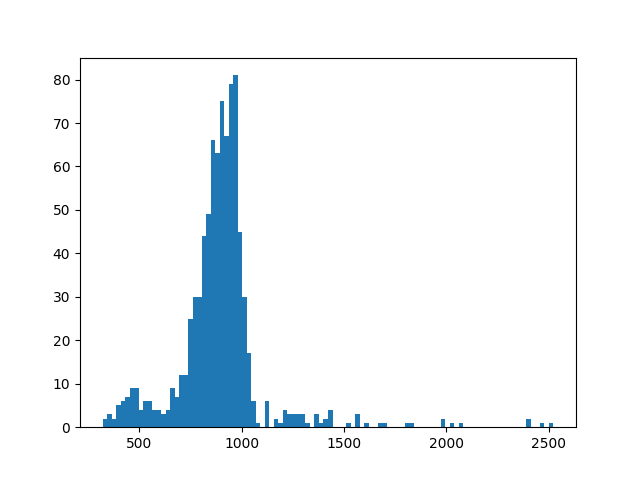

In [29]:
fig ,ax = plt.subplots()

ax.hist(rris, bins = 100)
plt.show()

In [30]:
rris_filtered = rris[ rris > 600]

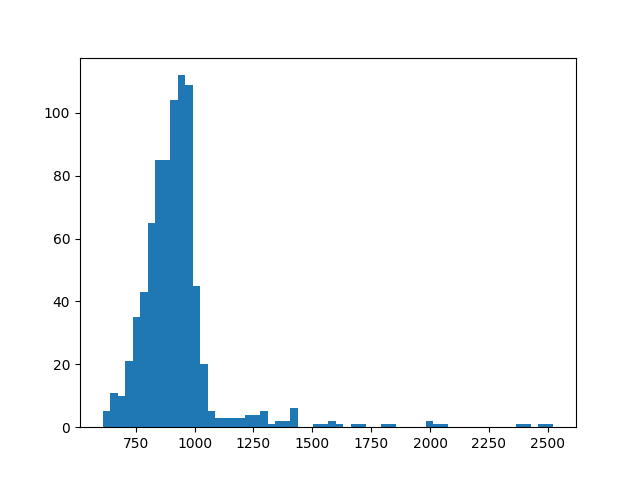

In [31]:
fig ,ax = plt.subplots()

ax.hist(rris_filtered, bins = 60)
plt.show()

In [32]:
np.median(rris_filtered)

908.9999999999918

In [33]:
1000 / 840 * 60

71.42857142857143

In [34]:
gh.hrv_metrics_from_rris(rris_filtered)

,MeanNN,SDNN,RMSSD,pNN50,SD1,SD2,S
0,927.523515,194.642353,239.752327,0.001238,169.530299,216.891091,115515.14144


In [35]:
df = pd.read_excel('/crnldata/cmo/Etudiants/NBuonviso2022_Emosens1_O+O-_Valentin/Tables/hrv.xlsx', index_col = 0)

In [36]:
df

,participant,session,odeur,bloc,trial,MeanNN,SDNN,RMSSD,pNN50,LF,HF,LFHF,SD1,SD2,S
0,P01,ses02,odor_-,Free,1,790.525066,69.328184,67.187962,0.002639,11.872353,20.087065,0.591045,47.508321,85.451433,1.275378e+04
0,P01,ses02,odor_-,Free,2,839.338936,204.530000,280.823818,0.002801,55.636444,83.262642,0.668204,198.572237,210.780896,1.314921e+05
0,P01,ses02,odor_-,Slow,1,1411.087302,1138.764737,1718.314781,0.007937,819.922176,1836.910241,0.446359,1215.023244,1064.984133,4.065160e+06
0,P01,ses02,odor_-,Slow,2,811.723982,294.374882,346.915270,0.004525,123.916951,65.544023,1.890591,245.299081,335.643042,2.586565e+05
0,P01,ses02,odor_-,Slow,3,915.892857,548.341836,758.432527,0.005102,44.368337,46.711349,0.949841,536.292754,562.700968,9.480461e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,P18,ses04,odor_o,Comfort,2,1025.920000,115.216390,101.202540,0.005714,51.226158,91.142671,0.562044,71.560995,146.700355,3.298051e+04
0,P18,ses04,odor_o,Comfort,3,1027.287356,126.953237,66.776480,0.005747,3.251319,5.474260,0.593928,47.174208,171.522678,2.542003e+04
0,P18,ses04,odor_o,Fast,1,970.597826,93.517850,69.831530,0.005435,8.149261,1.923323,4.237074,49.369856,122.436227,1.898986e+04
0,P18,ses04,odor_o,Fast,2,954.909091,133.823402,87.286052,0.005348,21.562128,36.977643,0.583113,61.718488,179.311618,3.476751e+04


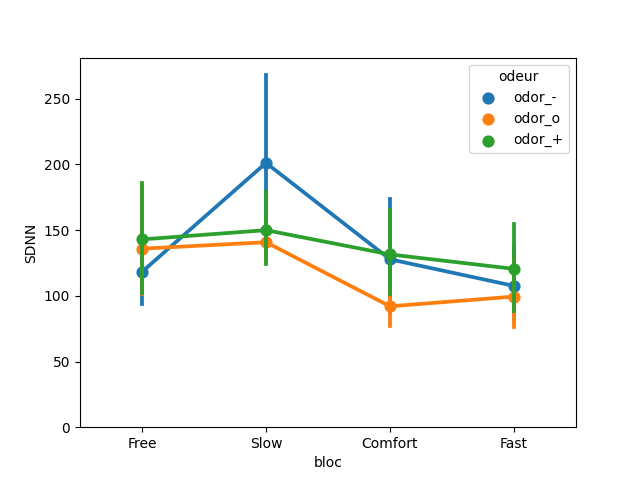

In [37]:
sns.pointplot(data = df , x = 'bloc', y = 'SDNN', hue = 'odeur')
plt.show()

/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(pred

<AxesSubplot: title={'center': 'Effect of odeur on SDNN : ns \n N = 16 subjects * 3 groups (*11 trial/group) \n friedman : p-0.7788'}, xlabel='odeur', ylabel='SDNN'>

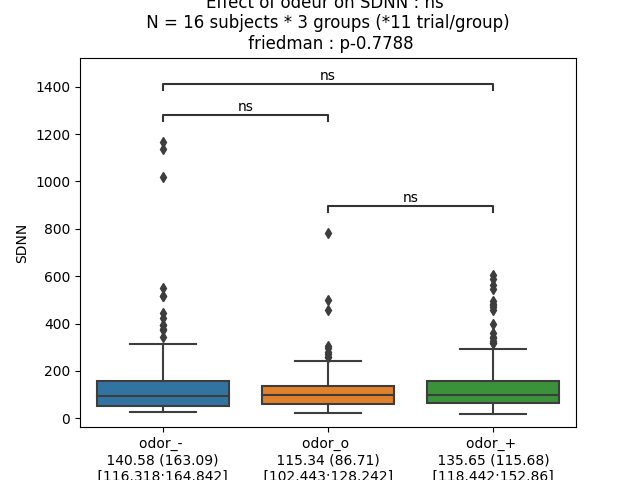

In [38]:
gh.auto_stats(df= df , predictor = 'odeur', outcome = 'SDNN', design = 'within', subject = 'participant')

/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(pred

<AxesSubplot: title={'center': 'Effect of bloc on SDNN : **** \n N = 16 subjects * 4 groups (*9 trial/group) \n friedman : p-0.0'}, xlabel='bloc', ylabel='SDNN'>

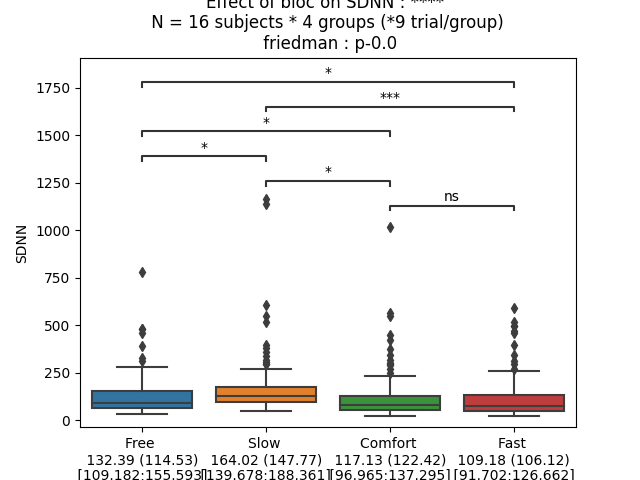

In [39]:
gh.auto_stats(df= df , predictor = 'bloc', outcome = 'SDNN', design = 'within', subject = 'participant')

In [40]:
f, Pxx = gh.spectre(fci, srate, lowest_freq = 0.05)

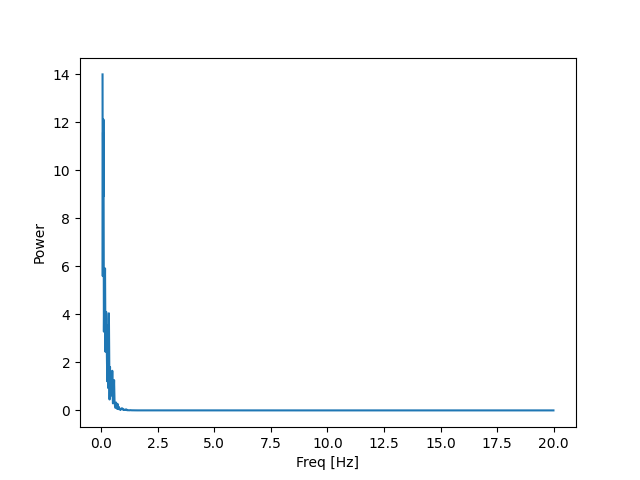

In [41]:
fig, ax =  plt.subplots()
mask = (f> 0.05) & (f < 20)
ax.plot(f[mask] , Pxx[mask])
ax.set_ylabel('Power')
ax.set_xlabel('Freq [Hz]')
plt.show()

In [42]:
mask_alpha = (f> 8) & (f < 12)

In [43]:
np.sum(Pxx[mask_alpha])

5.51603346216021e-08

In [49]:
sd = 5
mean = 100
data_odeur = np.random.randn(30) * sd + 100
data_son = np.random.randn(30) * sd + 100
data_control =  np.random.randn(30) * sd + 100

df_controle = pd.DataFrame(data_control, columns = ['HRV_RMSSD'])
df_controle['Stimulus'] = 'control'
df_odeur = pd.DataFrame(data_odeur, columns = ['HRV_RMSSD'])
df_odeur['Stimulus'] = 'odor'
df_son = pd.DataFrame(data_son, columns = ['HRV_RMSSD'])
df_son['Stimulus'] = 'music'

In [50]:
df = pd.concat([df_controle, df_son, df_odeur])

Text(0, 0.5, 'HRV_RMSSD [ms]')

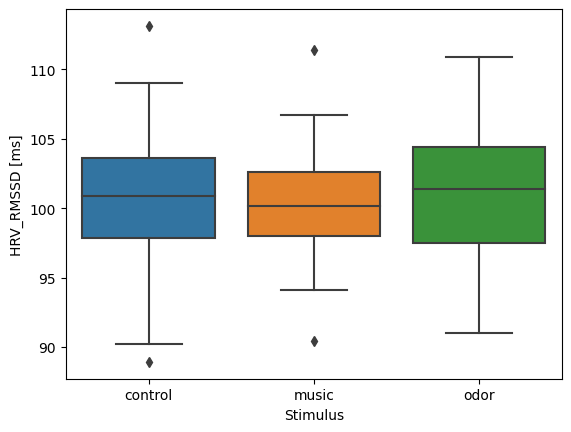

In [51]:
fig, ax = plt.subplots()
sns.boxplot(data = df, x = 'Stimulus', y = 'HRV_RMSSD', ax=ax)
ax.set_ylabel('HRV_RMSSD [ms]')
# plt.savefig('/crnldata/cmo/Etudiants/NBuonviso2023_Emosens3_OdeurSon_Valentin_Matthias/Biblio/Annexes/simulation_hrv')

<AxesSubplot: title={'center': 'Effect of Stimulus on HRV_RMSSD : ns \n N = 30 values/group * 3 groups \n anova : p-0.7581, np2 : 0.006 (VS)'}, xlabel='Stimulus', ylabel='HRV_RMSSD'>

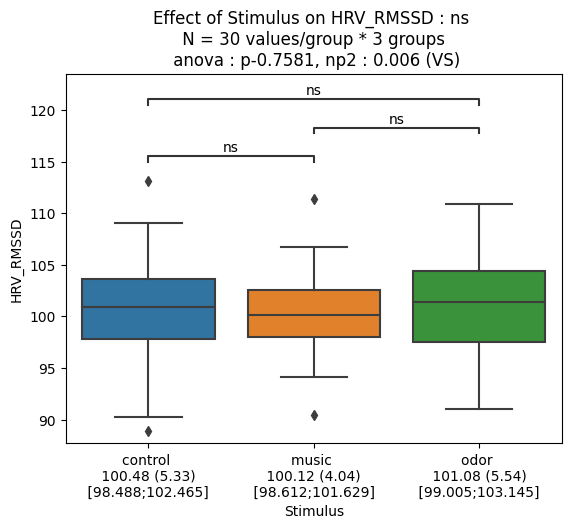

In [52]:
gh.auto_stats(df = df, predictor = 'Stimulus', outcome = 'HRV_RMSSD', design = 'between')